# WFA Application to DKIST/ViSP Ca II 8542 Data ##

In [29]:
import numpy as np
from scipy.special import voigt_profile
from scipy.integrate import simpson
from scipy import constants
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from numpy.polynomial import polynomial as P
from scipy.stats import pearsonr
from rhanalyze.satlas import satlas
from tqdm.notebook import tqdm
import matplotlib.pyplot as mpl
from astropy.io import fits
import glob
import dkist

In [30]:
def monotonic_increasing(x):
    dx = np.diff(x)
    return np.all(dx > 0)

def table_invert(table, values, mode=None):
    
    if np.ndim(table) == 0:
        print("Table cannot be a scalar!")
        return table
        
    t_array = np.array(table)
    
    if np.size(t_array) <= 1:
        print("Table cannot have one element!")
        return t_array
    
    if monotonic_increasing(t_array) == False:
        print("Table has to be monotonically increasing!")
        return None
    
    if np.ndim(values) == 0:
        v_array = np.array([values])
    else:  
        v_array = np.array(values)
    
    lookup = []
    for v in v_array:
        if v <= t_array[0]:
            lookup.append({"index": 0, "value": t_array[0], "eff_index": 0})
        elif v >= t_array[-1]:
            lookup.append({"index": len(t_array)-1, "value": t_array[-1], "eff_index": len(t_array)-1})
        else:
            index = np.argmin(np.abs(t_array - v))

            if v > t_array[index]:
                eff_index = index + (v - t_array[index]) / (t_array[index+1] - t_array[index])
            else:
                eff_index = index - 1 + \
                (v - t_array[index-1]) / (t_array[index] - t_array[index-1])
            
            lookup.append({"index": index, "value": t_array[index], "eff_index": eff_index})
    
    if mode == "effective":
        return np.array([dict["eff_index"] for dict in lookup])
    elif mode == "index":
        return np.array([dict["index"] for dict in lookup])
    else:
        return lookup

In [31]:
def LimbDark(wavelength, mu):
    
  ## Calculate limb-darkening coefficient (I_wavelength(mu) / I_wavelength(mu=1))
  ## as function of wavelength wavelength and cosine of viewing angle mu

  ## Reference: Allen's Astrophysical Quantities, 4th edition,
  ##             Arthur N. Cox, ed., Springer, p. 355, table 14.17

  ## Input:   wavelength  -- Wavelength [nm]
  ##              mu  -- Cosine of viewing angle (can be an array)

  MICRON_TO_NM = 1.0E3
    
  ## Coefficients from table 14.17, section 14.7

  clv = [{"wavelength": 0.20,  "u2":  0.12,  "v2":  0.33}, \
      
         {"wavelength": 0.22,  "u2": -1.30,  "v2":  1.60}, \
         {"wavelength": 0.245, "u2": -0.1,   "v2":  0.85}, \
         {"wavelength": 0.265, "u2": -0.1,   "v2":  0.90}, \
         {"wavelength": 0.28,  "u2":  0.38,  "v2":  0.57}, \
         {"wavelength": 0.30,  "u2":  0.74,  "v2":  0.20}, \
         {"wavelength": 0.32,  "u2":  0.88,  "v2":  0.03}, \
         {"wavelength": 0.35,  "u2":  0.98,  "v2": -0.10}, \
         {"wavelength": 0.37,  "u2":  1.03,  "v2": -0.16}, \
         {"wavelength": 0.38,  "u2":  0.92,  "v2": -0.05}, \
         {"wavelength": 0.40,  "u2":  0.91,  "v2": -0.05}, \
         {"wavelength": 0.45,  "u2":  0.99,  "v2": -0.17}, \
         {"wavelength": 0.50,  "u2":  0.97,  "v2": -0.22}, \
         {"wavelength": 0.55,  "u2":  0.93,  "v2": -0.23}, \
         {"wavelength": 0.60,  "u2":  0.88,  "v2": -0.23}, \
         {"wavelength": 0.80,  "u2":  0.73,  "v2": -0.22}, \
         {"wavelength": 1.0,   "u2":  0.64,  "v2": -0.20}, \
         {"wavelength": 1.5,   "u2":  0.57,  "v2": -0.21}, \
         {"wavelength": 2.0,   "u2":  0.48,  "v2": -0.18}, \
         {"wavelength": 3.0,   "u2":  0.35,  "v2": -0.12}, \
         {"wavelength": 5.0,   "u2":  0.22,  "v2": -0.07}, \
         {"wavelength": 10.0,  "u2":  0.15,  "v2": -0.07}]

  clv_waves = np.array([dict["wavelength"] for dict in clv]) * MICRON_TO_NM
  clv_u2    = np.array([dict["u2"] for dict in clv])  
  clv_v2    = np.array([dict["v2"] for dict in clv]) 

  fu2 = interpolate.interp1d(clv_waves, clv_u2)                      
  fv2 = interpolate.interp1d(clv_waves, clv_v2)     

  u2 = fu2(wavelength)
  v2 = fv2(wavelength)

  return 1.0 - u2 - v2 + mu * (u2 + mu*v2) 

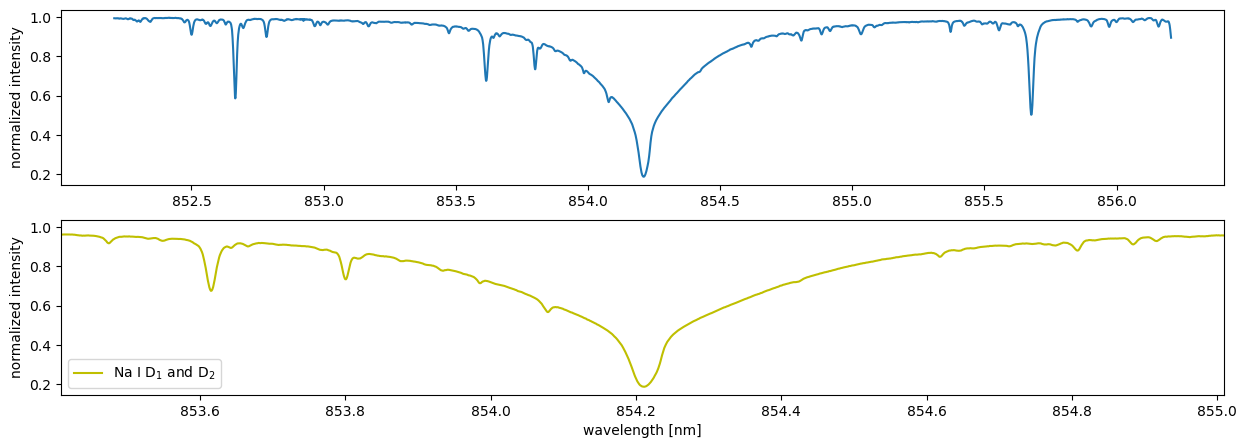

In [32]:
## read the whole atlas

fts = satlas()

## Now get the spectral region around the Sodium D lines in SI units and plot.

lambda0 = 854.2091
atlas   = fts.nmsiatlas(lambda0-2.0, lambda0+2.0)

### (wave_atl, I_atl, cont_atl) = fts.nmsiatlas(lambda0-15.0, lambda0+15.0)
norm_atlas = atlas[1] / atlas[2]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,5))
axs[0].plot(atlas[0], norm_atlas)
axs[0].set(ylabel='normalized intensity')

axs[1].plot(atlas[0], norm_atlas, label='Na I D$_1$ and D$_2$', color='y', linewidth=1.5)
axs[1].set(xlim=[853.4091, 855.0091], xlabel='wavelength [nm]', ylabel='normalized intensity')
axs[1].legend()

plt.show()

In [33]:
## Get de ViSP map for Ca II 8542

ViSP_arm_3_directory = '/Users/dato/NSO/GST_workshop/data/ViSP/BDDLM/'

CaII_854_asdf = glob.glob(ViSP_arm_3_directory + '*.asdf')
print(CaII_854_asdf)

CaII_854_dataset = dkist.load_dataset(CaII_854_asdf[0])

['/Users/dato/NSO/GST_workshop/data/ViSP/BDDLM/VISP_L1_20231016T201826_BDDLM.asdf']


In [34]:
hdu_list = fits.open('/Users/dato/NSO/GST_workshop/data/ViSP/BDDLM/VISP_2023_10_16T20_18_26_504_00854200_Q_BDDLM_L1.fits')
hdu_list.info()
hdu_list[1].header

Filename: /Users/dato/NSO/GST_workshop/data/ViSP/BDDLM/VISP_2023_10_16T20_18_26_504_00854200_Q_BDDLM_L1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  observation    1 CompImageHDU    309   (2549, 936, 1)   float64   


XTENSION= 'IMAGE   '                                                            
BITPIX  =                  -64                                                  
NAXIS   =                    3                                                  
NAXIS1  =                 2549 / [pix]                                          
NAXIS2  =                  936 / [pix]                                          
NAXIS3  =                    1 / [pix]                                          
PCOUNT  =                    0                                                  
GCOUNT  =                    1                                                  
BUNIT   = 'ct      '                                                            
DATE    = '2024-02-28T06:54:31.434'                                             
DATE-BEG= '2023-10-16T20:18:26.504'                                             
DATE-END= '2023-10-16T20:18:26.880'                                             
TELAPSE =  0.376000022515654

In [35]:
VISP_3_PIX_SIZE = 0.0194   ## pixel size along the slit, arm 3, in arcsec
VISP_SLIT       = 0.1071   ## slit width, in arcsec

spectrum_854 = CaII_854_dataset[:, :, :, :].data
Nst, Nscan, Nwave, Npix = spectrum_854.shape
print(Nst, Nscan, Nwave, Npix)

4 425 936 2549


In [36]:
spectrum_854.shape

(4, 425, 936, 2549)

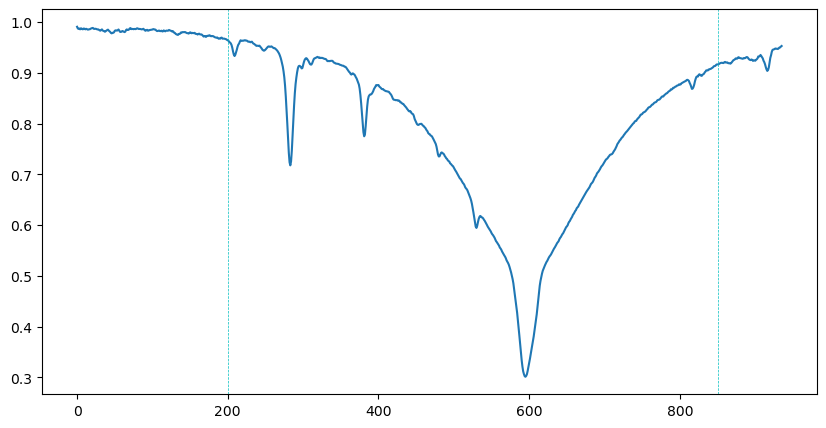

In [37]:
sample_spectrum = spectrum_854[0,300, :, 300].compute()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(sample_spectrum)

nlam0, nlam1 = (200, 850)

ax.axvline(nlam0, linewidth=0.5, color='c', linestyle='--')
ax.axvline(nlam1, linewidth=0.5, color='c', linestyle='--')
plt.show()

<Figure size 1400x400 with 0 Axes>

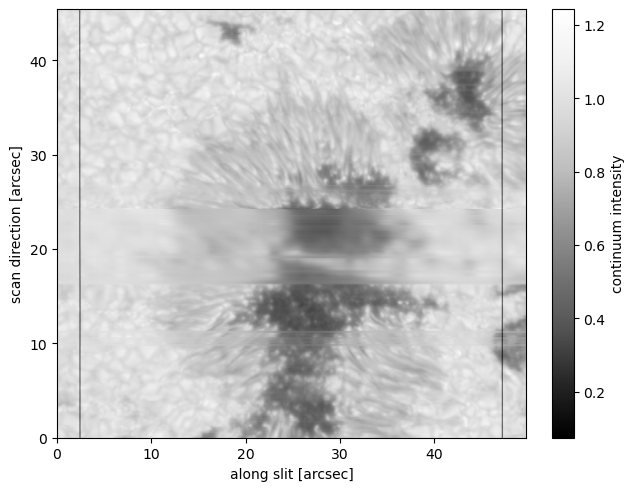

In [38]:
VISP_3_PIX_SIZE = 0.0195  
xarcsec = VISP_3_PIX_SIZE * np.arange(0, Npix)
yarcsec = VISP_SLIT * np.arange(0, Nscan)

cont_img = spectrum_854[0,:, nlam0, :].compute()

plt.figure(figsize=(14, 4))
cmap_grey = plt.cm.Greys.reversed()
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

im = ax.imshow(cont_img[:,:], origin='lower', cmap=cmap_grey,\
               #vmin=0.3, vmax=1.2, \
               extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]])


ax.set(ylabel='scan direction [arcsec]', xlabel='along slit [arcsec]')
plt.colorbar(im, label='continuum intensity')

plt.show()

<Figure size 1400x400 with 0 Axes>

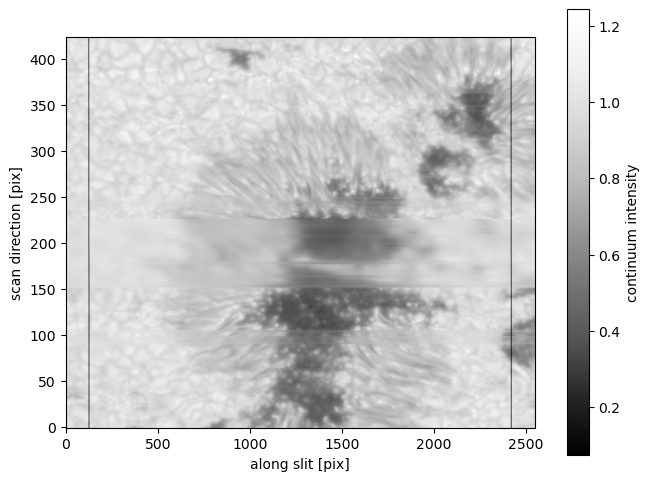

In [39]:

xarcsec = VISP_3_PIX_SIZE * np.arange(0, Npix)
yarcsec = VISP_SLIT * np.arange(0, Nscan)

cont_img = spectrum_854[0,:, nlam0, :].compute()

plt.figure(figsize=(14, 4))
cmap_grey = plt.cm.Greys.reversed()
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True)

#im = ax.imshow(cont_img[:,:], origin='lower', cmap=cmap_grey,\
#               #vmin=0.3, vmax=1.2, \
#               extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]])

im = ax.imshow(cont_img[:,:], origin='lower', cmap=cmap_grey, aspect=5)

ax.set(ylabel='scan direction [pix]', xlabel='along slit [pix]')
plt.colorbar(im, label='continuum intensity')

plt.show()

(202, 2549)


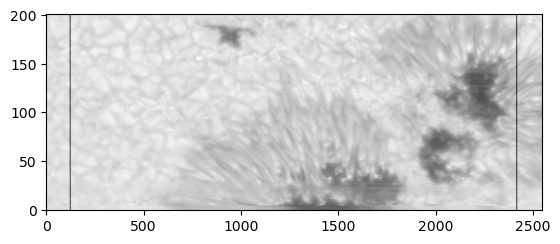

In [40]:
npix0, npix1 = (122, 2390)
nscan0, nscan1=(223, 425)

#data_854 = np.transpose(spectrum_854[0:150, nlam0:nlam1, npix0:npix1].compute(), axes=(2, 0, 1))
data_854 = spectrum_854[0,nscan0:nscan1, 58].compute()

plt.imshow(data_854[:,:],origin='lower',aspect=5,cmap=cmap_grey, )

print(data_854.shape)

(Nscan, Npix) = data_854.shape

xarcsec  = VISP_3_PIX_SIZE * np.arange(0, Npix)
yarcsec  = VISP_SLIT * np.arange(0, Nscan)

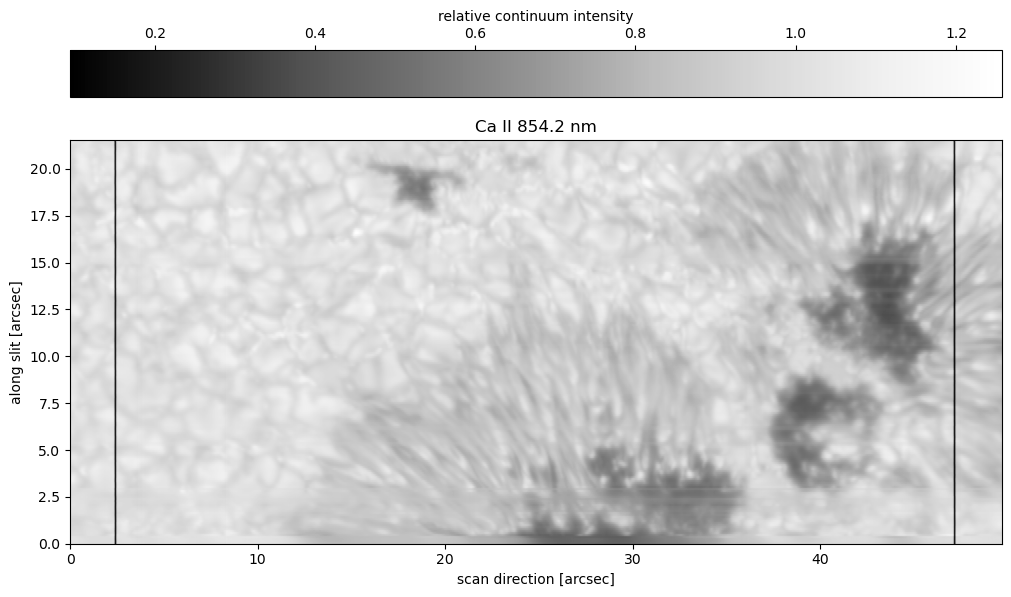

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(10,6))

im = ax.imshow(data_854[:, :], cmap=cmap_grey, \
               #vmin=0.55, vmax=1.2, \
               origin='lower', \
               extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]], aspect=1)
ax.set(ylabel='along slit [arcsec]', xlabel = 'scan direction [arcsec]', title='Ca II 854.2 nm')

plt.colorbar(im, label='relative continuum intensity', location='top')
plt.show()

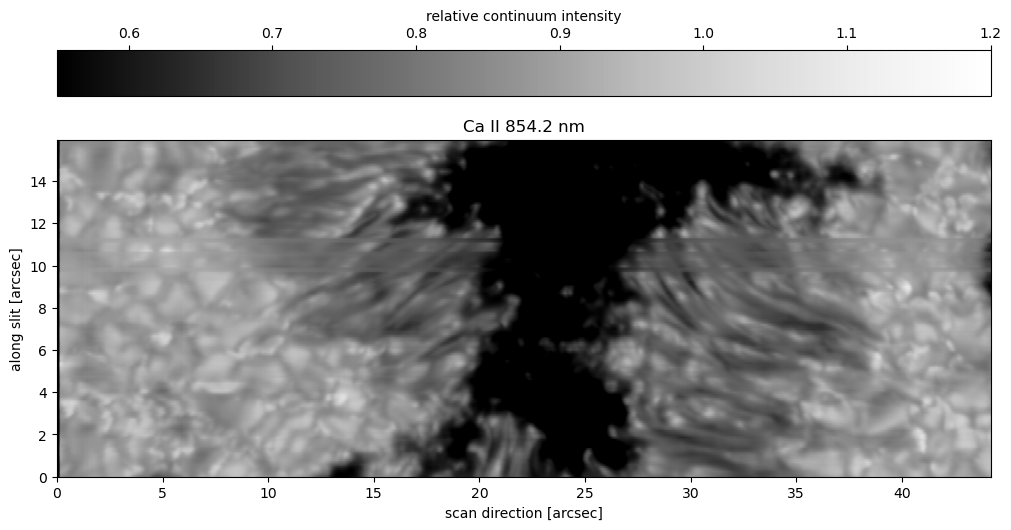

In [42]:
npix0, npix1 = (122, 2390)
nscan0, nscan1=(0, 150)

#data_854 = np.transpose(spectrum_854[0:150, nlam0:nlam1, npix0:npix1].compute(), axes=(2, 0, 1))
data_854 = spectrum_854[0,nscan0:nscan1, nlam0:nlam1, npix0:npix1].compute()

(Nscan, Nwave, Npix) = data_854.shape

xarcsec  = VISP_3_PIX_SIZE * np.arange(0, Npix)
yarcsec  = VISP_SLIT * np.arange(0, Nscan)

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(10,6))

im = ax.imshow(data_854[:, nlam0, :], cmap=cmap_grey, \
               vmin=0.55, vmax=1.2, \
               origin='lower', \
               extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]], aspect=1)
ax.set(ylabel='along slit [arcsec]', xlabel = 'scan direction [arcsec]', title='Ca II 854.2 nm')

plt.colorbar(im, label='relative continuum intensity', location='top')
plt.show()

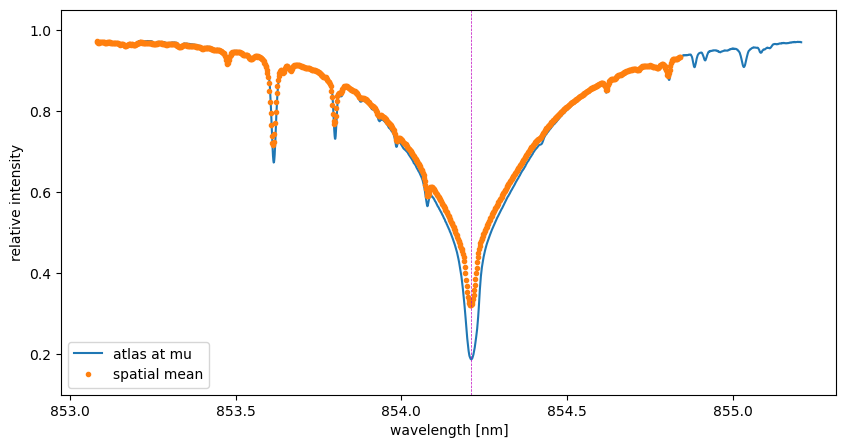

In [43]:
# matching observed spectra to ATLAS
data_854 = spectrum_854[0,:, :, 0:100].compute()
mean_spectrum = np.mean(data_854, axis=(0,2 ))

MU_OBS         = 0.991
MILLI          = 1.0E-3
NM_TO_ANGSTROM = 10.0
#LAM_STEP_630   = 
#LAM_BLUE_630   =  853.70127 ## OBS_ID = 'BRWJV'

#lambda_step    = LAM_STEP_630 * MILLI / NM_TO_ANGSTROM
#wavelength_630 = LAM_BLUE_630 + np.arange(0, Nwave, dtype='double') * lambda_step

i=np.arange(936) 
wavelength_854=853.1749+1.88966E-3*i-7.506692E-9*i*i


lambda0 = 854.2091
(wave_atl, I_atl, cont_atl) = fts.nmsiatlas(lambda0-1., lambda0+1)
norm_atl = I_atl / cont_atl
norm_atl_mu = norm_atl * LimbDark(lambda0, MU_OBS)

max_index   = np.argmax(mean_spectrum)
#atlas_index = table_invert(wave_atl, wavelength_854[max_index], mode="index")
arm3_norm   = norm_atl_mu[0] / mean_spectrum[max_index]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

#axs[0].plot(wave_atl, norm_atl, label='atlas')
#axs[0].plot(wavelength_854, mean_spectrum, '.', label='spatial mean')
#axs[0].axhline(1.0, color='c', linestyle='--', linewidth=0.5, label='disk center continuum')
#axs[0].set(ylim=[0.2, 1.05], ylabel='relative intensity')
           
axs.plot(wave_atl, norm_atl_mu, label='atlas at mu')
axs.plot(wavelength_854-0.094, mean_spectrum*arm3_norm, '.', label='spatial mean')
#axs.axhline(1.0, color='c', linestyle='--', linewidth=0.5, label='disk center continuum')
axs.axvline(lambda0, linewidth=0.5, color='m', linestyle='--')
axs.set(ylim=[0.1, 1.05], xlabel='wavelength [nm]', ylabel='relative intensity')

wav854=wavelength_854-854.2091-0.094

axs.legend()

plt.show()

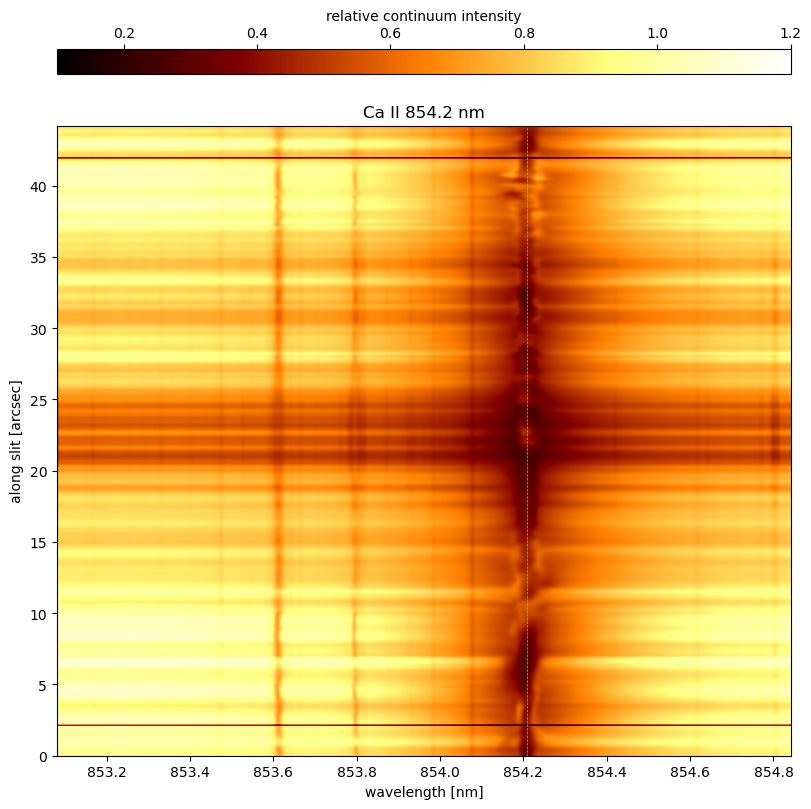

In [45]:
slit_pos = 61

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(8,8))

im = ax.imshow(np.transpose(spectrum_854[0, slit_pos, :, :]), cmap='afmhot', \
               vmin=0.1, vmax=1.2, \
               origin='lower', aspect='auto', \
               extent=[wavelength_854[0]-0.094, wavelength_854[-1]-0.094, xarcsec[0], xarcsec[-1]])
ax.axvline(lambda0, linewidth=0.5, color='y', linestyle='--')
ax.set(ylabel='along slit [arcsec]', xlabel = 'wavelength [nm]', title='Ca II 854.2 nm')

plt.colorbar(im, label='relative continuum intensity', location='top', aspect=30)
plt.show()

# WFA for B_los #

>$ V = -C B_{LOS} \frac{\partial I}{\partial \lambda}$


where:

>$C = 4.6686\times 10^{-13}* \lambda_0^2 * g_{eff}$

where $\lambda$ is in Angstroms, and, for Ca II 8542 Ang 

$L(\lambda_0) = \frac{3}{4}B_{T}^2 \left|C_{T}\frac{1}{\lambda_w-\lambda_0}\right|\left|\frac{\partial I}{\partial \lambda}\right|$

where $C_T=[4.6686\times 10^{-13} \lambda_0^2]^2 \bar{G}$


In [49]:
# constants
c = constants.speed_of_light #speed of light in m/s
mu = 40.078 # atomic weight of calcium
M = constants.atomic_mass  #1.66e-27 # kg (atomic mass unit)
Kb = constants.Boltzmann #1.38E-23 # m^2 kg s^-2 K^-1 (Boltzmann constant)

# wavelength grid in Ca II 8542 Angtsom 
lam0 = 8542.086  # central wavelength in Angs
lam=10*(wavelength_854-0.094)  #in Angstroms
dlam=lam-lam0


# Lande g-factors for Ca II 8542
glos_eff = 1.1                  
gtrn_eff = 1.205 

fac  = 4.6686E-13*(lam0**2)    # some proportionality constants for WFA analysis
Clos = fac*glos_eff
Ctrn = (fac**2)*gtrn_eff


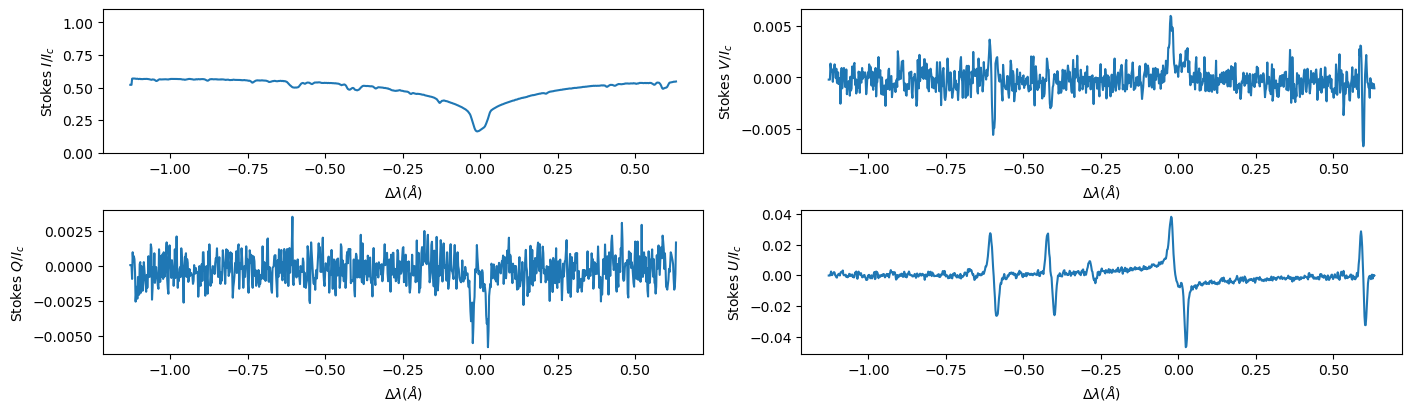

In [50]:
#x and y for representative Stokes I/Q/U/V profiles
#ix = 2200 #180
#iy = 390 #311
ix = 1389 #180
iy = 2 #311
ang = r'$\AA$'
#xti='wavelength ['+ang+']'
xti=r'$\Delta \lambda (\AA)$'

fig, axs = plt.subplots(figsize=(14, 4),nrows=2, ncols=2, constrained_layout=True)

axs[0][0].plot(wav854, spectrum_854[0, iy,:, ix])
axs[0][0].set(xlabel=xti,ylabel=r'Stokes $I/I_c$')
axs[0][0].set(ylim=[0.0, 1.1])

#axs[0][0].text(0.8, 8543, 'Here is some text in the first subplot')
#axs[0][0].legend()
#axs[1][1].text(1.1, 8536, 'Fibril at 75",33"', fontsize = 1, color='white')

axs[0][1].plot(wav854, spectrum_854[1, iy,:, ix])
axs[0][1].set(xlabel=xti,ylabel=r'Stokes $V/I_c$')

axs[1][0].plot(wav854, spectrum_854[2, iy,:, ix])
axs[1][0].set(xlabel=xti, ylabel=r'Stokes $Q/I_c$')

axs[1][1].plot(wav854, spectrum_854[3, iy,:, ix])
axs[1][1].set(xlabel=xti, ylabel=r'Stokes $U/I_c$')
plt.show()
#fig.savefig(fig_dir + "CaII_8542_fit_" + scanID + ".pdf", format="pdf", bbox_inches="tight")""
#fig.savefig(paper_fig_dir + "spect_fib.pdf", format="pdf", bbox_inches="tight")


<Figure size 1400x400 with 0 Axes>

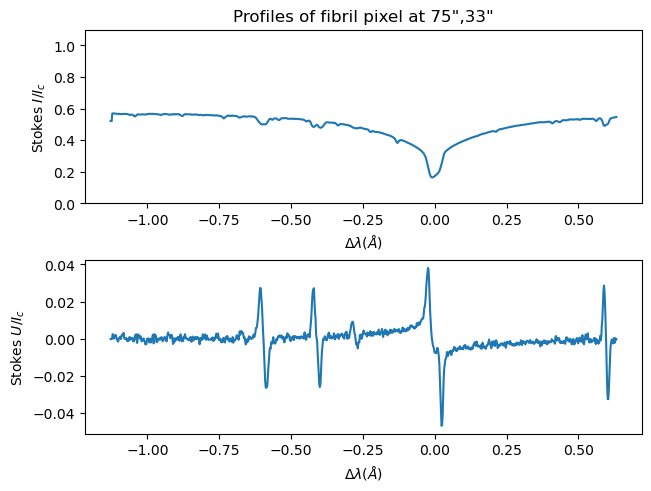

In [51]:
#representative Stokes I and V profilea
#ix = 2300 #180
#iy = 350 #311
ang = r'$\AA$'

plt.figure(figsize=(14, 4))
fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True)

axs[0].plot(wav854, spectrum_854[0, iy,:, ix])
axs[0].set(xlabel=xti,ylabel=r'Stokes $I/I_c$',title='Profiles of fibril pixel at 75",33"')
axs[0].set(ylim=[0.0, 1.1])

axs[1].plot(wav854, spectrum_854[3, iy,:, ix])
axs[1].set(xlabel=xti, ylabel=r'Stokes $U/I_c$')
plt.show()
#fig.savefig(fig_dir + "CaII_8542_fit_" + scanID + ".pdf", format="pdf", bbox_inches="tight")""
#fig.savefig(paper_fig_dir + "spect_fib.pdf", format="pdf", bbox_inches="tight")


<h2>WFA for $B_{LOS}$</h2>
<h0>First we will apply the WFA near line core<h0>

       Bfit  = 569.6 Gauss, with intercept = -0.0003538283196521773
0.9895434387195687


<function matplotlib.pyplot.show(close=None, block=None)>

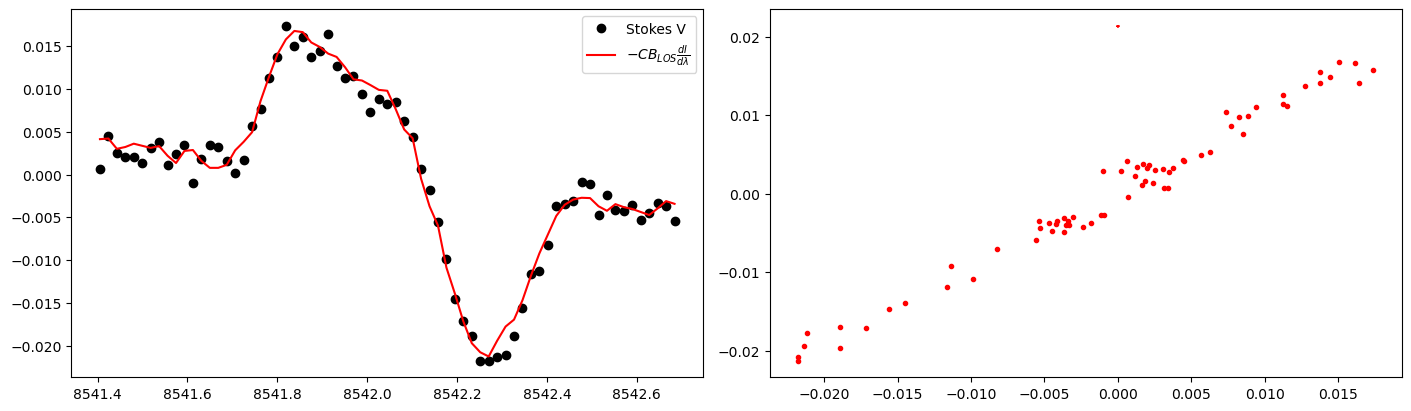

In [58]:

#representative Stokes I profile
ix = 2340 #180
iy = 280 #311

# Wavelength range to chop spectral line of interest (in our case, Ca II 8542)
# line core only
wl1 = 8541.4
wl2 = 8542.7

# read Stokes profiles for ix,iy
SI=spectrum_854[0, iy,:, ix].compute()
SQ=spectrum_854[1, iy,:, ix].compute()
SU=spectrum_854[2, iy,:, ix].compute()
SV=spectrum_854[3, iy,:, ix].compute()

# derivative of I with respect to wavelength. 
dIdlam = np.gradient(SI, lam)

## Start figure
fig, ax = plt.subplots(figsize=(14, 4),nrows=1, ncols=2, constrained_layout=True)

# Cut out wavelength range around Ca II 8542
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))  
lam_line = np.squeeze(lam[indlam])
Iline=np.squeeze(SI[indlam])
Vline = np.squeeze(SV[indlam])
dIdlam = np.squeeze(dIdlam[indlam])

# Calculate Blos
# Perform a linear fit of Stokes V to -C*dI/dlam to obtain Blos
Bfit = P.polyfit(-Clos*dIdlam, Vline, 1)

# plot Stokes V and overplot dI/dlam scaled with C and Blos

ax[0].plot(lam_line, Vline, 'ko', label='Stokes V')
ax[0].plot(lam_line, -Bfit[1]*Clos*dIdlam, 'r-', label=r'$-C B_{LOS}\frac{dI}{d\lambda}$') 
#ax[int(Bvalue/100-1)].set_title('B = '+str(Bvalue)+' G')
#ax[int(Bvalue/100-1)].set_xlabel(r'$\lambda - \lambda_0\, (\AA) $')
#ax[0].legend()

corr, _ = pearsonr(Vline, -Bfit[1]*Clos*dIdlam)
#cc      = '%.3f'%(corr)

#Print out results
print('       Bfit  = ' +format(Bfit[1], '5.1f') + ' Gauss, with intercept = '+str(Bfit[0]))
print(corr) 

ax[1].plot(Vline, -Bfit[1]*Clos*dIdlam, ".",color="r")
ax[1].plot(Clos*dIdlam,-Bfit[1]*dIdlam*Bfit[0]*Clos+Bfit[1]*Clos,label='fit', color="r" )
#ax[1].annotate('strong linear\n correlation,\n CC = '+cc, xy=(0, 0), xytext=(250, -500), fontsize=12, 
#             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})
ax[0].legend()

plt.show

<h1>Now lets apply the WFA on the line wing</h1>

In [60]:
#wfaparms     = wfa_blos(Vline, lam_line, dIdlam, Clos)
#print, wfaparms

       Bfit  = 472.4 Gauss, with intercept = -6.429750785525081e-05
0.7211939532595744


<function matplotlib.pyplot.show(close=None, block=None)>

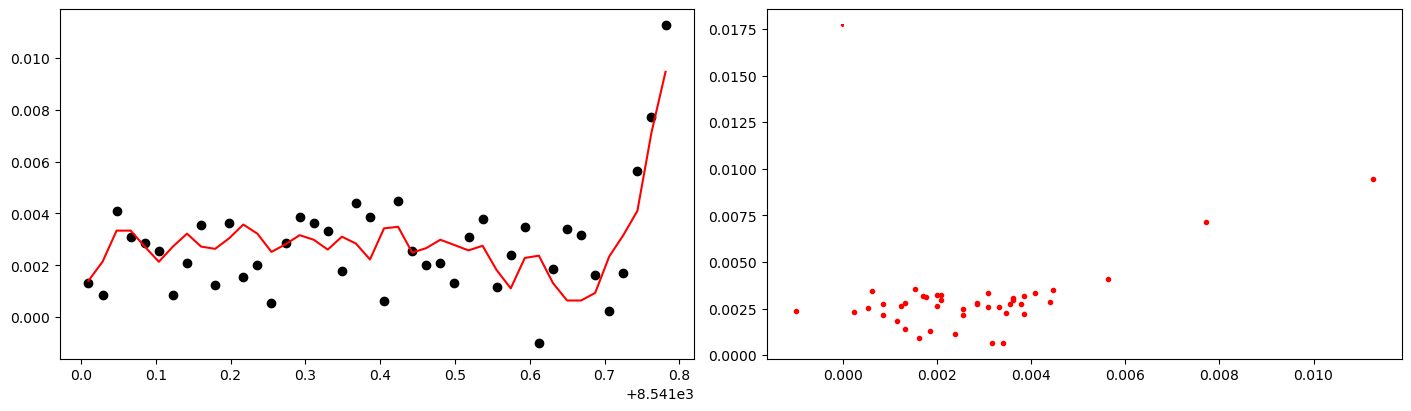

In [61]:
#representative Stokes I profile

ix = 2340 #180
iy = 280 #311

# Line wing wavelength range to cut spectral line of interest (in our case, Ca II 8542)
wl1 = 8541.0
wl2 = 8541.8


# read Stokes profiles for x,y
SI=spectrum_854[0, iy,:, ix].compute()
SQ=spectrum_854[1, iy,:, ix].compute()
SU=spectrum_854[2, iy,:, ix].compute()
SV=spectrum_854[3, iy,:, ix].compute()


## Start figure

fig, ax = plt.subplots(figsize=(14, 4),nrows=1, ncols=2, constrained_layout=True)

# derivative of I with respect to wavelength. 
dIdlam = np.gradient(SI, lam)

# Cut out wavelength range around Ca II 8542
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))  
lam_wing = np.squeeze(lam[indlam])
Iwing=np.squeeze(SI[indlam])
Vwing = np.squeeze(SV[indlam])
dIdlam = np.squeeze(dIdlam[indlam])

Bfit = P.polyfit(-Clos*dIdlam, Vwing, 1)

# plot Stokes V and overplot dI/dlam scaled with C and Blos

ax[0].plot(lam_wing, Vwing, 'ko', label='Stokes V')
ax[0].plot(lam_wing, -Bfit[1]*Clos*dIdlam, 'r-', label=r'$-C B_{LOS}\frac{dI}{d\lambda}$') 
#ax[int(Bvalue/100-1)].set_title('B = '+str(Bvalue)+' G')
#ax[int(Bvalue/100-1)].set_xlabel(r'$\lambda - \lambda_0\, (\AA) $')
#ax[0].legend()


fit     = np.polyval(Bfit, -Bfit[1]*Clos*dIdlam)
corr, _ = pearsonr(Vwing, -Bfit[1]*Clos*dIdlam)
cc      = '%.3f'%(corr)

print('       Bfit  = ' +format(Bfit[1], '5.1f') + ' Gauss, with intercept = '+str(Bfit[0]))
print(corr) 

ax[1].plot(Vwing, -Bfit[1]*Clos*dIdlam, ".",color="r")
ax[1].plot(Clos*dIdlam,-Bfit[1]*dIdlam*Bfit[0]*Clos+Bfit[1]*Clos,label='fit', color="r" )
#ax[1].annotate('strong linear\n correlation,\n CC = '+cc, xy=(0, 0), xytext=(250, -500), fontsize=12, 
#             arrowprops={'width':0.4,'headwidth':7,'color':'#333333'})

    # Calculate Blos
    # Perform a linear fit of Stokes V to -C*dI/dlam to obtain Blos

#Bfit = P.polyfit(-C*dIdlam_line, Vline, 1)
    
    #Print out results
    
#ax[0].legend()
#plt.tight_layout()
plt.show

In [64]:
def wfa_blos(SV, wave, dI_dlam, C_los):
    #
    # Calculate the LOS field strength from the Weak Field Approximation
    #
    #   @param   :  SV      :  [float nparray(ns,nw)]  :  Stokes profile data for a single pixel
    #   @param   :  wave      :  [float nparray(nw)]     :  Observed wavelengths [Ang]       
    #   @param   :  dI_dlam  :  [float nparray(nw)]     :  Derivative of Stokes I profile w.r.t.
    #                                                       wavelength
    #   @param   :  c_los     :  [float]                 :  Scaling factor for LOS field
    #   @return  :  blos      :  [float]                 :  LOS field strength [G]
    
    try:
        # linear regression
        blos = -np.sum(dI_dlam*SV)/( C_los*np.sum(dI_dlam**2 ) )
    except ZeroDivisionError:
        blos = 0.

    return blos
####################################################################################################

####################################################################################################
def wfa_btrn( SQ, SU, wave, dI_dlam, c_trn, lc):
    #
    # Calculate the transverse field strength from the Weak Field Approximation
    #
    #   @param   :  SQ,SU,SV      :  [float nparray(ns,nw)]  :  Stokes profile data for a single pixel
    #   @param   :  wave      :  [float nparray(nw)]     :  Observed wavelengths [Ang]        
    #   @param   :  dI_dlam  :  [float nparray(nw)]     :  Derivative of Stokes I profile w.r.t.
    #                                                       wavelength
    #   @param   :  c_trn     :  [float]                 :  Scaling factor for transverse field
    #   @param   :  lc        :  [float]                 :  Observed line-center wavelength [Ang]
    #   @return  :  btrn      :  [float]                 :  Transverse field strength [G]
    #

    factor  = (4./(3.*c_trn))*np.sqrt( SQ**2 + SU**2 )
    lam_offset = 1./(wave - lc)
    product    = abs( lam_offset )*abs( dI_dlam )
    try:
        # linear regression
        btrn = np.sqrt( np.sum( factor*product )/np.sum( product**2 ) )
    except ZeroDivisionError:
        btrn = 0.
  
    return btrn

####################################################################################################

####################################################################################################
def wfa_binc( blos, btrn ):
    #
    # Calculate the magnetic field inclination from the Weak Field Approximation
    #
    #   @param   :  blos  :  [float]  :  LOS field strength [G] for a single pixel
    #   @param   :  btrn  :  [float]  :  Transverse field strength [G] for a single pixel
    #
    #   @return  :  binc  :  [float]  :  Field inclination [deg]
    #

    binc = np.arctan2( btrn, blos )*(180./np.pi)

    return binc
####################################################################################################



In [65]:
#blos  = wfa_blos(SV, lam_line, dIdlam, Clos)
#blos  = wfa_btrn(Vline, lam_line, dIdlam, Con)
#print, blos

blos  = wfa_blos(Vwing,lam_wing, dIdlam, Clos)
print, blos

#SV.shape, lam_line.shape



(<function print(*args, sep=' ', end='\n', file=None, flush=False)>,
 463.9641227318634)

In [66]:
#print, lam0, lam

<h2> WFA approximation for the horizontal component of the field ($B_{TRN}$)</h2>

$L(\lambda_0) = \frac{3}{4}B_{T}^2 \left|C_{T}\frac{1}{\lambda_w-\lambda_0}\right|\left|\frac{\partial I}{\partial \lambda}\right|$



In [67]:
print, Ctrn

(<function print(*args, sep=' ', end='\n', file=None, flush=False)>,
 1.3983508035653648e-09)

Bt WFA = 1307.0 Gauss, with intercept = 0.000408831
Bt WFA = 1363.7 gauss, without intercept


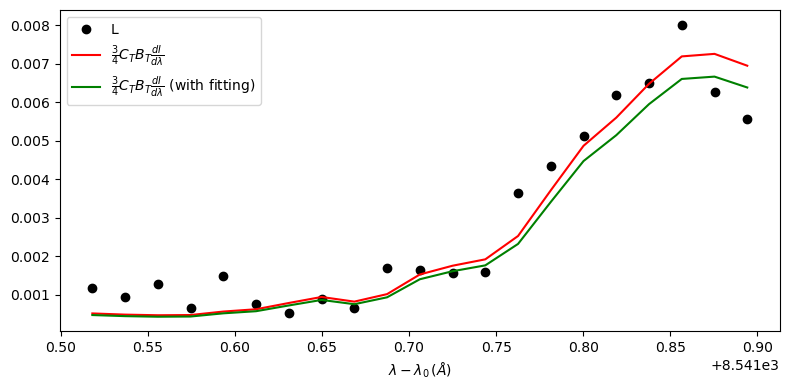

In [68]:
#representative Stokes I profile
ix = 1389 #180
iy = 2 #311

# wing of line
#wl1 = -0.1
#wl2 = 0.1

# Wavelength range to chop spectral line of interest (in our case, Ca II 8542) (line core only)
wl1 = 8541.5
wl2 = 8541.9


# read Stokes profiles for x,y
SI=spectrum_854[0, iy,:, ix].compute()
SQ=spectrum_854[1, iy,:, ix].compute()
SU=spectrum_854[2, iy,:, ix].compute()
SV=spectrum_854[3, iy,:, ix].compute()

# derivative of I with respect to wavelength. 
dIdlam = np.gradient(SI, lam)

#Cut out wavelength range of interest
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))  
lam_wing = np.squeeze(lam[indlam])

SI = np.squeeze(SI[indlam])
SQ = np.squeeze(SQ[indlam])
SU = np.squeeze(SU[indlam])
SV = np.squeeze(SV[indlam])

dIdlam = np.squeeze(dIdlam[indlam])

## total linear polarization
TLP = np.sqrt(SQ**2. + SU**2.)  


# Compute the right-hand side of the WFA equation, 
dfactor = 3/4.* Ctrn * np.abs(1./(lam_wing-lam0))*np.abs(dIdlam)

# First perform linear fit without intercept
Bt  = wfa_btrn(SQ,SU,lam_wing, dIdlam, Ctrn, lam0)

# Calculate Bt
# Perform a linear fit of Stokes L to dI/dlam to obtain Bt
# Because the model (WFA) is a linear fit without an intercept,
# We can force the intercept to zero, or alternatively use it as a 
# sanity check for the fit.

# First perform linear fit without intercept
#slope = np.sum(TLP * dfactor)/ np.sum(dfactor**2.)
# the slope beta corresponds to Bt**2, so we extract Bt 
#Bt = np.sqrt(beta)

#slope = np.sum(TLP * dfactor)/ np.sum(dfactor**2.)


# Then repeat linear fit with intercept
from numpy.polynomial import polynomial as P
# perform a linear fit with intercept, for comparison
Bfit = P.polyfit(dfactor,TLP, 1)

print('Bt WFA = ' +format(np.sqrt(Bfit[1]),'6.1f') + ' Gauss, with intercept = '+format(Bfit[0], '6.9f'))  
print('Bt WFA = '+ format(Bt,'6.1f')+ ' gauss, without intercept')
#print('Bt Model = '+ format(Bt_mod, '6.1f') + ' gauss')

#### FIGURE: plot L and overplot d2I/dlam2 scaled with C and Blos
fig, ax = plt.subplots(figsize = (8, 4))

ax.plot(lam_wing, TLP, 'ko', label='L')
ax.plot(lam_wing, Bt**2*dfactor, 'r-', label=r'$\frac{3}{4}C_T B_{T} \frac{dI}{d\lambda}$') 
ax.plot(lam_wing, Bfit[1]*dfactor, 'g-', label=r'$\frac{3}{4}C_T B_{T} \frac{dI}{d\lambda}$ (with fitting)')

#ax.set_title('B = '+str(Bvalue)+' G')
ax.set_xlabel(r'$\lambda - \lambda_0\, (\AA) $')
ax.legend()
plt.tight_layout()

<h2> WFA approximation for the horizontal component of the field ($B_{LOS}$) for selected sub-FOV</h2>

(69, 152, 1950)

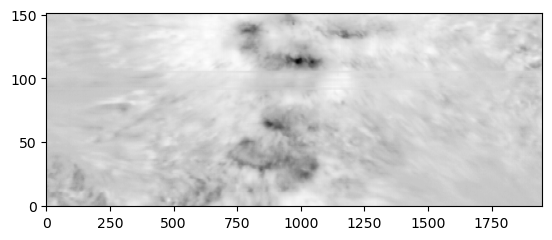

In [77]:
#Cut out region of interest
#area = [ 500,  2400,  223, 325 ]        # [x1,x2,y1,y2] bounding box
area = [ 400,  2350,  0, 152]        # [x1,x2,y1,y2] bounding box

data_854 = spectrum_854[:,area[2]:area[3],:,area[0]:area[1]].compute()

#Cut out wavelength range of interest for line core
wl1 = 8541.4
wl2 = 8542.7

#Cut out wavelength range of interest
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))  
lam_line = np.squeeze(lam[indlam])

SI = np.squeeze(data_854[0,:,indlam,:])
SQ = np.squeeze(data_854[1,:,indlam,:])
SU = np.squeeze(data_854[2,:,indlam,:])
SV = np.squeeze(data_854[3,:,indlam,:])

plt.imshow(SV[25,:,:],origin='lower',aspect=5,cmap=cmap_grey)

SV.shape


In [78]:
(Nwave,Nscan,Npix) = SI.shape

area = [0,  Npix-1,  0, Nscan-1]        # [x1,x2,y1,y2] bounding box

nx = area[1] - area[0] + 1
ny = area[3] - area[2] + 1

#ar_lam0   = np.zeros( (ny,nx) )    # we will look at these maps below
#ar_lam0zc = np.zeros( (ny,nx) )

data      = np.zeros( (4, Nwave) )

ar_blos = np.zeros( (ny,nx) )
ar_btrn = np.zeros( (ny,nx) )
ar_binc = np.zeros( (ny,nx) )
ar_bazm = np.zeros( (ny,nx) )

lam0_nom = 8542.0910               # nominal line-core wavelength [Ang]

for y in tqdm(range(0,ny)):        # tqdm just displays a progress bar for an iterable.
    scan = area[2] + y
    for x in range(0,nx):
        pix       = area[0] + x
        data[0,:] = np.squeeze( SI[:,scan,pix] )
        data[1,:] = np.squeeze( SU[:,scan,pix] )
        data[2,:] = np.squeeze( SQ[:,scan,pix] )
        data[3,:] = np.squeeze( SV[:,scan,pix] )
        dIdlam = np.gradient(SI[:,scan,pix], lam_line)
        
        
        #ar_lam0[y,x]   = wfa.calc_lam0_cog( np.squeeze(data[0,ws:we]), wobs[ws:we], lam0_nom )
        #ar_lam0zc[y,x] = wfa.calc_lam0_vzc( np.squeeze(data[3,ws:we]), wobs[ws:we], lam0_nom )
        
        if np.abs(data[3,25])>0.0005:
            wfaparms     = wfa_blos(data[3,:], lam_line, dIdlam, Clos )
            ar_blos[y,x] = wfaparms
        else:
            ar_blos[y,x] = 0
        
        #ar_btrn[y,x] = wfaparms[2]
        #ar_binc[y,x] = wfaparms[4]
        #ar_bazm[y,x] = wfaparms[5]
    pass

#
# The wfa.wfapprox function can also calculate also the photospheric field from the line wings...we
# will come back to this in a later exercise below.
#

  0%|          | 0/152 [00:00<?, ?it/s]

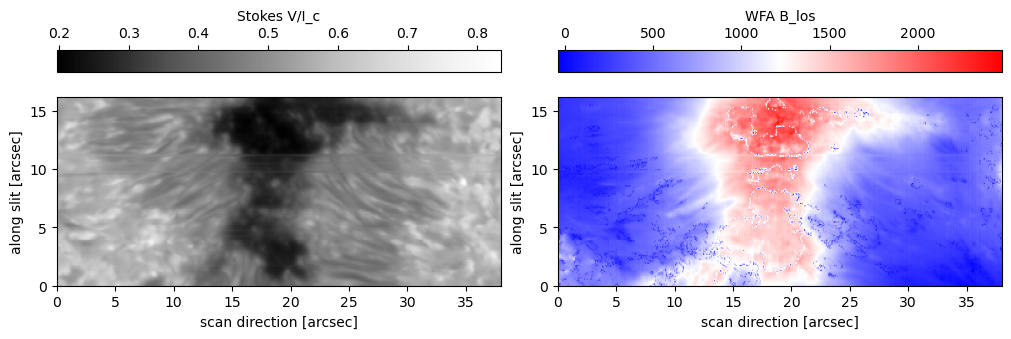

In [79]:

# display maps

cmap_grey = plt.cm.Greys.reversed()
#data_854 = np.transpose(spectrum_854[0:150, nlam0:nlam1, npix0:npix1].compute(), axes=(2, 0, 1))
#data_854 = spectrum_854[0,nscan0:nscan1, nlam0:nlam1, npix0:npix1].compute()

#(Nscan, Nwave, Npix) = data_854.shape

xarcsec  = VISP_3_PIX_SIZE * np.arange(0, Npix)
yarcsec  = VISP_SLIT * np.arange(0, Nscan)

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,6))

im1 = ax[0].imshow(SI[0,:,:], cmap=cmap_grey, \
               #vmin=-0.04, vmax=0.04, \
               origin='lower', \
               extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]], aspect=1)
ax[0].set(ylabel='along slit [arcsec]', xlabel = 'scan direction [arcsec]')
plt.colorbar(im1, label='Stokes V/I_c', location='top')

im2 = ax[1].imshow(ar_blos, cmap="bwr", \
               #vmin=-200, vmax=2500, \
               origin='lower', \
               extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]], aspect=1)
ax[1].set(ylabel='along slit [arcsec]', xlabel = 'scan direction [arcsec]')



plt.colorbar(im2, label='WFA B_los', location='top')
#print, ar_blos[125,600]
plt.show()
#print, ar_blos[125,600]

<h1>Check quality of fits between derivative of Stokes I vs Stokes V for individual pixels</h1>

(<function print(*args, sep=' ', end='\n', file=None, flush=False)>,
 1255.1384274421355)

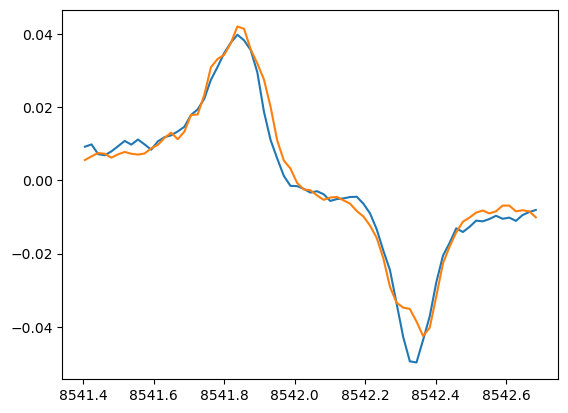

In [80]:
(Nwave,Nscan,Npix) = SI.shape

area = [0,  Npix-1,  0, Nscan-1]        # [x1,x2,y1,y2] bounding box

nx = area[1] - area[0] + 1
ny = area[3] - area[2] + 1

data      = np.zeros( (4, 69) )

ar_blos = np.zeros( (ny,nx) )

scan=3
pix=1000

data[0,:] = np.squeeze( SI[:,scan,pix] )
data[1,:] = np.squeeze( SU[:,scan,pix] )
data[2,:] = np.squeeze( SQ[:,scan,pix] )
data[3,:] = np.squeeze( SV[:,scan,pix] )
dIdlam = np.gradient(SI[:,scan,pix], lam_line)
#dIdlam = np.squeeze( dIdlam )
        
        
        #ar_lam0[y,x]   = wfa.calc_lam0_cog( np.squeeze(data[0,ws:we]), wobs[ws:we], lam0_nom )
        #ar_lam0zc[y,x] = wfa.calc_lam0_vzc( np.squeeze(data[3,ws:we]), wobs[ws:we], lam0_nom )
        
wfaparms     = wfa_blos(data[3,:], lam_line, dIdlam, Clos)
        #ar_blos[y,x] = wfaparms
        #ar_btrn[y,x] = wfaparms[2]
        #ar_binc[y,x] = wfaparms[4]
        #ar_bazm[y,x] = wfaparms[5]


plt.plot(lam_line, SV[:,scan,pix])
plt.plot(lam_line, -wfaparms*Clos*dIdlam)

print, wfaparms

#
# The wfa.wfapprox function can also calculate also the photospheric field from the line wings...we
# will come back to this in a later exercise below.
#

<h2> WFA approximation for the horizontal component of the field ($B_{TRN}$)</h2>

$L(\lambda_0) = \frac{3}{4}B_{T}^2 \left|C_{T}\frac{1}{\lambda_w-\lambda_0}\right|\left|\frac{\partial I}{\partial \lambda}\right|$


(21, 152, 1950)

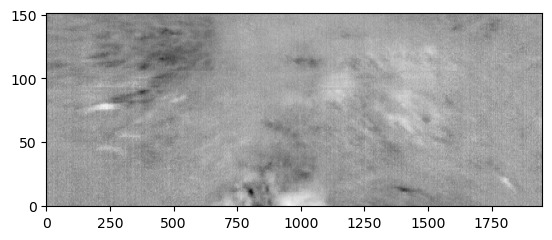

In [81]:
#Cut out region of interest
#area = [ 500,  2400,  223, 325 ]        # [x1,x2,y1,y2] bounding box
area = [ 400,  2350,  0, 152]        # [x1,x2,y1,y2] bounding box

data_854 = spectrum_854[:,area[2]:area[3],:,area[0]:area[1]].compute()
 
#Cut out wavelength range of interest for line wing
wl1 = 8541.5
wl2 = 8541.9


#Cut out wavelength range of interest
indlam = np.argwhere(np.logical_and(lam>=wl1, lam<=wl2))  
lam_wing = np.squeeze(lam[indlam])

SI = np.squeeze(data_854[0,:,indlam,:])
SQ = np.squeeze(data_854[1,:,indlam,:])
SU = np.squeeze(data_854[2,:,indlam,:])
SV = np.squeeze(data_854[3,:,indlam,:])

plt.imshow(SQ[20,:,:],origin='lower',aspect=5,cmap=cmap_grey)

SV.shape


In [82]:
(Nwave,Nscan,Npix) = SI.shape

area = [0,  Npix-1,  0, Nscan-1]        # [x1,x2,y1,y2] bounding box

nx = area[1] - area[0] + 1
ny = area[3] - area[2] + 1

#ar_lam0   = np.zeros( (ny,nx) )    # we will look at these maps below
#ar_lam0zc = np.zeros( (ny,nx) )

data      = np.zeros( (4, Nwave) )

#ar_blos = np.zeros( (ny,nx) )
ar_btrn = np.zeros( (ny,nx) )
#ar_binc = np.zeros( (ny,nx) )
#ar_bazm = np.zeros( (ny,nx) )

lam0_nom = 8542.0910               # nominal line-core wavelength [Ang]

for y in tqdm(range(0,ny)):        # tqdm just displays a progress bar for an iterable.
    scan = area[2] + y
    for x in range(0,nx):
        pix       = area[0] + x
        data[0,:] = np.squeeze( SI[:,scan,pix] )
        data[1,:] = np.squeeze( SU[:,scan,pix] )
        data[2,:] = np.squeeze( SQ[:,scan,pix] )
        data[3,:] = np.squeeze( SV[:,scan,pix] )
        dIdlam = np.gradient(SI[:,scan,pix], lam_wing)
        

        if np.abs(data[2,17])>0.000005:
            btrn     = wfa_btrn(data[1,:],data[2,:],lam_wing, dIdlam, Ctrn, lam0_nom)
            ar_btrn[y,x] = btrn
        else:
            ar_btrn[y,x] = 0
        
        #ar_btrn[y,x] = wfaparms[2]
        #ar_binc[y,x] = wfaparms[4]
        #ar_bazm[y,x] = wfaparms[5]
    pass

#
# The wfa.wfapprox function can also calculate also the photospheric field from the line wings...we
# will come back to this in a later exercise below.
#

  0%|          | 0/152 [00:00<?, ?it/s]

In [83]:
data.shape, SI.shape,lam_wing.shape, dIdlam.shape


((4, 21), (21, 152, 1950), (21,), (21,))

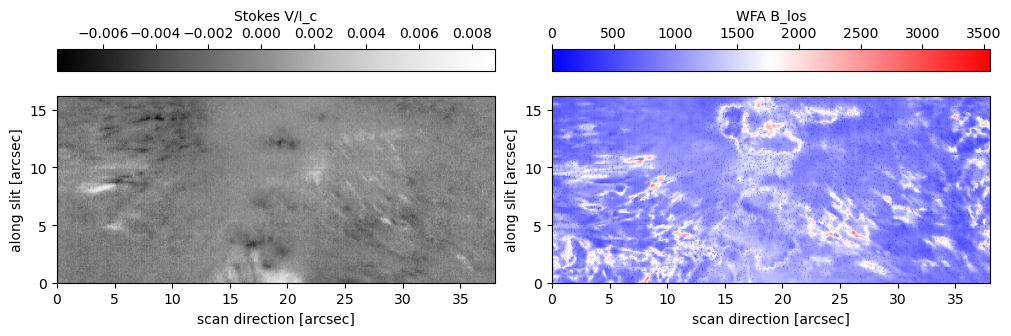

In [84]:
# display maps

cmap_grey = plt.cm.Greys.reversed()

#(Nscan, Nwave, Npix) = data_854.shape

xarcsec  = VISP_3_PIX_SIZE * np.arange(0, Npix)
yarcsec  = VISP_SLIT * np.arange(0, Nscan)

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,6))

im1 = ax[0].imshow(SQ[17,:,:], cmap=cmap_grey, \
               #vmin=-0.04, vmax=0.04, \
               origin='lower', \
               extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]], aspect=1)
ax[0].set(ylabel='along slit [arcsec]', xlabel = 'scan direction [arcsec]')
plt.colorbar(im1, label='Stokes V/I_c', location='top')

im2 = ax[1].imshow(ar_btrn, cmap="bwr", \
               #vmin=-2500, vmax=0, \
               origin='lower', \
               extent=[xarcsec[0], xarcsec[-1], yarcsec[0], yarcsec[-1]], aspect=1)
ax[1].set(ylabel='along slit [arcsec]', xlabel = 'scan direction [arcsec]')



plt.colorbar(im2, label='WFA B_los', location='top')
#print, ar_blos[125,600]
plt.show()
#print, ar_blos[125,600]

(<function print(*args, sep=' ', end='\n', file=None, flush=False)>,
 1329.635545141354,
 1315.5435306671257)

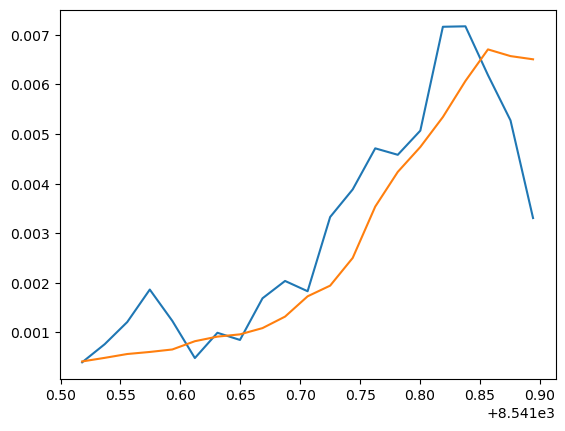

In [114]:
(Nwave,Nscan,Npix) = SI.shape

#area = [0,  Npix-1,  0, Nscan-1]        # [x1,x2,y1,y2] bounding box
#
# OK, let's extend this exercise to calculate WFA magnetic fields in a selected sub-FOV (Active Region)?
# Note that everything we've so far done manually for the single-pixel case is wrapped-up in the 
# wfa.wfapprox function...
#

#npix0, npix1 = (122, 2390)
#nscan0, nscan1=(223, 425)
#data_854 = spectrum_854[:,nscan0:nscan1, :,npix0:npix1].compute()
#plt.imshow(data_854[:,:],origin='lower',aspect=5,cmap=cmap_grey, )

#print(data_854.shape)

#nx = area[1] - area[0] + 1
#ny = area[3] - area[2] + 1

#ar_lam0   = np.zeros( (ny,nx) )    # we will look at these maps below
#ar_lam0zc = np.zeros( (ny,nx) )

data1      = np.zeros( (4, Nwave) )

#ar_blos = np.zeros( (ny,nx) )
#ar_btrn = np.zeros( (ny,nx) )
#ar_binc = np.zeros( (ny,nx) )
#ar_bazm = np.zeros( (ny,nx) )

lam0_nom = 8542.0910               # nominal line-core wavelength [Ang]

scan=2
pix=1000
data1[0,:] = np.squeeze( SI[:,scan,pix] )
data1[1,:] = np.squeeze( SU[:,scan,pix] )
data1[2,:] = np.squeeze( SQ[:,scan,pix] )
data1[3,:] = np.squeeze( SV[:,scan,pix] )
dIdlam = np.gradient(SI[:,scan,pix], lam_wing)
#dIdlam = np.squeeze( dIdlam )
        
        
        #ar_lam0[y,x]   = wfa.calc_lam0_cog( np.squeeze(data[0,ws:we]), wobs[ws:we], lam0_nom )
        #ar_lam0zc[y,x] = wfa.calc_lam0_vzc( np.squeeze(data[3,ws:we]), wobs[ws:we], lam0_nom )
        
wfaparms     = wfa_btrn(data1[1,:],data1[2,:],lam_wing, dIdlam, Ctrn, lam0)
        #ar_blos[y,x] = wfaparms
        #ar_btrn[y,x] = wfaparms[2]
        #ar_binc[y,x] = wfaparms[4]
        #ar_bazm[y,x] = wfaparms[5]

#TLP=np.sqrt(SQ[:,scan,pix]**2+SU[:,scan,pix]**2)

dfactor = 3/4.* Ctrn * np.abs(1./(lam_wing-lam0))*np.abs(dIdlam)

plt.plot(lam_wing, np.sqrt(data1[1,:]**2+data1[2,:]**2))
plt.plot(lam_wing, wfaparms**2*dfactor)

print, ar_btrn[scan,pix],wfaparms

#
# The wfa.wfapprox function can also calculate also the photospheric field from the line wings...we
# will come back to this in a later exercise below.
#

In [69]:
SQ.shape, dIdlam.shape
print, lam0

(<function print(*args, sep=' ', end='\n', file=None, flush=False)>, 8542.086)